# L02A. Regression Coefficients - Revisited

## Lesson Objectives

By the end of this lesson, students will be able to:

- Extract and visualize coefficients from sklearn regression model. 
- Select coefficients by magnitude/rank
- Deal with multicollinearity by dropping categories.
- Annotate horizontal bargraphs


## Introduction

- At the end of last stack, we dove deep into linear regression models and their assumptions. We introduced a new package called statsmodels, which produced a Linear Regression model using "Ordinary-Least-Squared (OLS)". 
- The model included a robust statistical summary that was incredibly informative as we critically diagnosed our regression model and if we met the assumptions of linear regression.
- This stack, we will be focusing on extracting insights from our models: both by examining parameters/aspects of the model itself, like the coefficients it calculated, but also by applying some additional tools and packages specifically designed to explain models. 

- Most of these tools are compatible with the scikit-learn ecosystem but are not yet available for statsmodels.

Since we are not focusing on regression diagnostics this week, we will shift back to using scikit-learn models.

# Extracting Coefficients from LinearRegression in scikit-learn

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## set text displays for sklearn
from sklearn import set_config
set_config(display='text')

In [2]:
## SETTING CUSTOM STYLES - ASK BRENDA ABOUT IF/HOW TO INCLUDE
from lp_styles import *
from lp_functions import evaluate_regression

In [3]:
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

In [4]:
## Load in the student performance - portugese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0


### Preprocessing + ColumnTransformer

In [5]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2']
y = df['G3'].copy()
X = df.drop(columns=['G3', *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15764e0a0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1103365b0>)],
                  verbose_feature_names_out=False)

In [6]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [7]:
## Using pd.set_option to display more columns
X_train_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


## Extracting Coefficients and Intercept from Scikit-Learn Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.35	RMSE= 2.65
Test Data:	R^2= 0.35	RMSE= 2.45


- For scikit-learn Linear Regressions, we can find the coefficients for the features that were included in our X-data under the `.coef_` attribute. 
-  the `.coef_` is a numpy matrix that should have the same number of values as the # of columns in X_train_df

In [10]:
lin_reg.coef_

array([ 1.76999907e-01,  8.69911716e-02,  2.12910358e-01,  2.50731620e-01,
        4.62451189e-01, -1.29508496e+00,  1.58616427e-01, -2.34882226e-01,
        5.33761237e-03, -2.12265606e-01, -7.15170929e-02, -1.23104390e-01,
       -2.90569146e-02,  3.68424091e+10,  3.68424091e+10, -4.81452473e+11,
       -4.81452473e+11,  3.66268608e+11,  3.66268608e+11,  1.53569663e+10,
        1.53569663e+10, -4.99481276e+10, -4.99481276e+10,  5.61954554e+11,
        5.61954554e+11,  5.61954554e+11,  5.61954554e+11,  5.61954554e+11,
        5.24684582e+11,  5.24684582e+11,  5.24684582e+11,  5.24684582e+11,
        5.24684582e+11, -3.35184100e+10, -3.35184100e+10, -3.35184100e+10,
       -3.35184100e+10, -1.11216121e+12, -1.11216121e+12, -1.11216121e+12,
        1.17325618e+12,  1.17325618e+12,  2.33588919e+11,  2.33588919e+11,
        5.06552539e+09,  5.06552539e+09, -6.41685959e+11, -6.41685959e+11,
        4.64385889e+10,  4.64385889e+10, -1.17996679e+12, -1.17996679e+12,
        7.02731930e+11,  

In [11]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

56


56

> Note: if for some reason the length of your coef_ is 1, you should add the `.flatten()` method to convert the  coef_ into a simple 1-D array.

### Saving the coefficients as a pandas Series

- We can immediately turn the the models' .coef_ into a pd.Series, as well.
    - Therefore, in our pd.Series, we will provide the `lin_reg.coef_` as the first argument, followed by `index=feature_names` (pandas Series are 1D and do not have columns)

In [12]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

age                  1.769999e-01
Medu                 8.699117e-02
Fedu                 2.129104e-01
traveltime           2.507316e-01
studytime            4.624512e-01
failures            -1.295085e+00
famrel               1.586164e-01
freetime            -2.348822e-01
goout                5.337612e-03
Dalc                -2.122656e-01
Walc                -7.151709e-02
health              -1.231044e-01
absences            -2.905691e-02
school_GP            3.684241e+10
school_MS            3.684241e+10
sex_F               -4.814525e+11
sex_M               -4.814525e+11
address_R            3.662686e+11
address_U            3.662686e+11
famsize_GT3          1.535697e+10
famsize_LE3          1.535697e+10
Pstatus_A           -4.994813e+10
Pstatus_T           -4.994813e+10
Mjob_at_home         5.619546e+11
Mjob_health          5.619546e+11
Mjob_other           5.619546e+11
Mjob_services        5.619546e+11
Mjob_teacher         5.619546e+11
Fjob_at_home         5.246846e+11
Fjob_health   

- The constant/intercept is not included in the .ceof_ attribute (if we used the default settings for LinearRegression which sets fit_intercept = True)
- The intercept is stored in the `.intercept_` attribute 
- We can add this as a new value to our coeffs series.
- Note: it is up to you what you name your intercept/constant. If you wanted to keep the naming convention of statsmodels, you could use "const" or just "intercept" for simplicity.

In [13]:
# use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

age                  1.769999e-01
Medu                 8.699117e-02
Fedu                 2.129104e-01
traveltime           2.507316e-01
studytime            4.624512e-01
failures            -1.295085e+00
famrel               1.586164e-01
freetime            -2.348822e-01
goout                5.337612e-03
Dalc                -2.122656e-01
Walc                -7.151709e-02
health              -1.231044e-01
absences            -2.905691e-02
school_GP            3.684241e+10
school_MS            3.684241e+10
sex_F               -4.814525e+11
sex_M               -4.814525e+11
address_R            3.662686e+11
address_U            3.662686e+11
famsize_GT3          1.535697e+10
famsize_LE3          1.535697e+10
Pstatus_A           -4.994813e+10
Pstatus_T           -4.994813e+10
Mjob_at_home         5.619546e+11
Mjob_health          5.619546e+11
Mjob_other           5.619546e+11
Mjob_services        5.619546e+11
Mjob_teacher         5.619546e+11
Fjob_at_home         5.246846e+11
Fjob_health   

### Suppressing Scientific Notation in Pandas

> We can ALSO use panda's options to change how it display numeric values.
- if we want to add a `,` separator for thousands and round to 2 decimal places, we would use the format code ",.2f". 
- In order for Pandas to use this, we will have to use an f-string with a lambda x. (X represent any numeric value being displayed by pandas).

In [14]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

age                                  0.18
Medu                                 0.09
Fedu                                 0.21
traveltime                           0.25
studytime                            0.46
failures                            -1.30
famrel                               0.16
freetime                            -0.23
goout                                0.01
Dalc                                -0.21
Walc                                -0.07
health                              -0.12
absences                            -0.03
school_GP               36,842,409,060.79
school_MS               36,842,409,059.33
sex_F                 -481,452,472,882.24
sex_M                 -481,452,472,882.90
address_R              366,268,608,059.92
address_U              366,268,608,060.16
famsize_GT3             15,356,966,308.00
famsize_LE3             15,356,966,308.49
Pstatus_A              -49,948,127,598.24
Pstatus_T              -49,948,127,597.96
Mjob_at_home           561,954,553

## Inspecting Our Coefficients - Sanity Check

- Hmmmm....hold on now. We saw last lesson that our target, G3, contained scores from 0 to 20. 
- So HOW IN THE WORLD does it make sense that your model's baseline value (the y-intercept) is 2 trillion?!?
- This may be due to us introducing multicollinearity during One Hot Encoding.

#### Using OneHotEncoder with binary categorical features.

- if we check just our string columns for the # of unique values:

In [15]:
df.select_dtypes('object').nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

## OneHotEncoding & Multicollinearity

- We can see that many of our categories only have 2 options.
    - For example: the paid feature.
        - One Hot Encoding this feature will create a "paid_no" column and "paid_yes" column.

- Here is where we should think about our final use case for this data. If we want to explain student performance, there is no benefit to one-hot-encoding both categories. 
    - We know that if someone has a 0 for "paid_yes" that it means "paid_no" would be 1. 
    
    
- To remove these unnecessary columns, we can change our arguments for our OneHotEncoder in our pipeline and add "drop='if_binary'" or "drop='first'/'last' to automatically drop one of the categories to reduce multicollinearity.
    - HOWEVER, we cannot use BOTH `handle_unknown` AND the `drop` argument together. We will get an error message.

- Since our current modeling will be used to extract insights for our stakeholder and will not be deployed to the cloud where it will run predictions on new data, we can safely switch to using the drop='if_binary' option.

### Recreating Our X/y data with `drop='if_binary'`

In [16]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.00,3.00,4.00,1.00,2.00,0.00,5.00,4.00,4.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
284,18.00,2.00,1.00,1.00,1.00,2.00,3.00,2.00,5.00,2.00,5.00,5.00,4.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
579,18.00,1.00,3.00,1.00,1.00,0.00,4.00,3.00,3.00,2.00,3.00,3.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00


- As we can see above, we now only have 1 version of our binary columns (e.g. "paid_yes","internet_yes")

#### Refitting a LinearRegression

In [17]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.35	RMSE= 2.65
Test Data:	R^2= 0.35	RMSE= 2.44


In [18]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

age                                  0.18
Medu                                 0.09
Fedu                                 0.21
traveltime                           0.25
studytime                            0.46
failures                            -1.29
famrel                               0.16
freetime                            -0.23
goout                                0.01
Dalc                                -0.21
Walc                                -0.07
health                              -0.12
absences                            -0.03
school_MS                           -1.46
sex_M                               -0.66
address_U                            0.23
famsize_LE3                          0.49
Pstatus_T                            0.27
Mjob_at_home           565,030,228,190.61
Mjob_health            565,030,228,191.53
Mjob_other             565,030,228,190.71
Mjob_services          565,030,228,190.97
Mjob_teacher           565,030,228,190.86
Fjob_at_home         2,058,131,492

- Hmm... we fixed the ceoffiicents for binary features like sex, school, romatnic, higher, etc. but are still getting some crazy coefficients for our categorical features with more than 2 options, such as reason, guardian, Fjob, Mjob.

### Recreating Our X/y data with `drop='first'`

In [19]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.00,3.00,4.00,1.00,2.00,0.00,5.00,4.00,4.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
284,18.00,2.00,1.00,1.00,1.00,2.00,3.00,2.00,5.00,2.00,5.00,5.00,4.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
579,18.00,1.00,3.00,1.00,1.00,0.00,4.00,3.00,3.00,2.00,3.00,3.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00


#### Refitting a LinearRegression

In [20]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.35	RMSE= 2.65
Test Data:	R^2= 0.35	RMSE= 2.45


In [21]:
# Tip: sklearn models now store the feature names in .feature_names_in_!
lin_reg.feature_names_in_

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3',
       'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other', 'schoolsup_yes', 'famsup_yes',
       'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes',
       'internet_yes', 'romantic_yes'], dtype=object)

In [22]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

age                  0.18
Medu                 0.09
Fedu                 0.21
traveltime           0.25
studytime            0.46
failures            -1.29
famrel               0.16
freetime            -0.23
goout                0.01
Dalc                -0.21
Walc                -0.07
health              -0.12
absences            -0.03
school_MS           -1.46
sex_M               -0.66
address_U            0.23
famsize_LE3          0.49
Pstatus_T            0.27
Mjob_health          0.92
Mjob_other           0.10
Mjob_services        0.36
Mjob_teacher         0.25
Fjob_health         -1.16
Fjob_other          -0.38
Fjob_services       -0.81
Fjob_teacher         0.95
reason_home          0.12
reason_other        -0.22
reason_reputation   -0.07
guardian_mother     -0.38
guardian_other      -0.03
schoolsup_yes       -1.31
famsup_yes          -0.01
paid_yes            -0.48
activities_yes       0.29
nursery_yes         -0.40
higher_yes           1.69
internet_yes         0.30
romantic_yes

- OK, now THESE coefficients pass our sanity check. They are all values <1, which seems appropriate for predicting a value between 0 and 100.



>- Note that by dropping first, we no longer have a coefficient associated with the first category of each categorical feature. 
    - For example, we no longer have a coefficient for "reason_course". 
    - While this will improve our linear regression model's performance, we are losing out on some additional insights. 

    


 

### Selecting which category to drop 

Since our main goal this week is extracting insights from our model, it would be much better if we could select WHICH category should be dropped. 
- For example, dropping "other" for any feature that has an "other" category, dropping "no" for every feature with yes/no,etc.


We can actually do this with OneHotEncoder as well! 

- We can provide a list of categories to drop to OneHotEncoder as the drop argument.
- The list will need an category for each categorical feature. 

In [23]:
## using our cat_sel to get the list of categorical features
cat_sel(X)

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [24]:
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For school:
['GP' 'MS']

For sex:
['F' 'M']

For address:
['U' 'R']

For famsize:
['GT3' 'LE3']

For Pstatus:
['A' 'T']

For Mjob:
['at_home' 'health' 'other' 'services' 'teacher']

For Fjob:
['teacher' 'other' 'services' 'health' 'at_home']

For reason:
['course' 'other' 'home' 'reputation']

For guardian:
['mother' 'father' 'other']

For schoolsup:
['yes' 'no']

For famsup:
['no' 'yes']

For paid:
['no' 'yes']

For activities:
['no' 'yes']

For nursery:
['yes' 'no']

For higher:
['yes' 'no']

For internet:
['no' 'yes']

For romantic:
['no' 'yes']



#### Specifying the category to drop for each feature

In [25]:
drop_cats = ['GP', 'M', 'R', 'LE3', 'A', 'other', 'other', 'other', 
             'other', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']

In [26]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop=drop_cats, sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_F,address_U,famsize_GT3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,guardian_father,guardian_mother,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.00,3.00,4.00,1.00,2.00,0.00,5.00,4.00,4.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
284,18.00,2.00,1.00,1.00,1.00,2.00,3.00,2.00,5.00,2.00,5.00,5.00,4.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
579,18.00,1.00,3.00,1.00,1.00,0.00,4.00,3.00,3.00,2.00,3.00,3.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00


#### Refitting a LinearRegression

In [27]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.35	RMSE= 2.65
Test Data:	R^2= 0.35	RMSE= 2.45


- Since we will be extracting coefficients from multiple models, let's convert our code for extracting coefficients into a function.
- Let's have the feature names as an optional argument. If they are not provided, we can just grab them from the model's .feature_names_in_.
- Let's also allow for the option of sorting the coefficients too (to save time).
- Finally, let's accept a name to use for our series so we can easily keep track of different coefficients using their name.

In [28]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_

    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
    return coeffs

## UPDATED 09/14/22
# def get_coeffs_linreg(lin_reg, feature_names = None, intercept=False,
#                       sort=True,ascending=True,
#                      name='LinearRegression Coefficients'):
#     if feature_names is None:
#         feature_names = lin_reg.feature_names_in_

#     ## Saving the coefficients
#     coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    
#     if intercept == True:
#         coeffs['intercept'] = lin_reg.intercept_
    
#     if sort==True:
#         coeffs = coeffs.sort_values(ascending=ascending)
    
#     return coeffs

In [29]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

school_MS           -1.46
schoolsup_yes       -1.31
failures            -1.29
Fjob_health         -0.77
famsize_GT3         -0.49
paid_yes            -0.48
Fjob_services       -0.42
romantic_yes        -0.42
nursery_yes         -0.40
guardian_mother     -0.35
freetime            -0.23
Dalc                -0.21
health              -0.12
Mjob_at_home        -0.10
Walc                -0.07
absences            -0.03
famsup_yes          -0.01
goout                0.01
guardian_father      0.03
Medu                 0.09
reason_reputation    0.14
Mjob_teacher         0.15
famrel               0.16
age                  0.18
Fedu                 0.21
reason_course        0.22
address_U            0.23
traveltime           0.25
Mjob_services        0.26
Pstatus_T            0.27
activities_yes       0.29
internet_yes         0.30
reason_home          0.33
Fjob_at_home         0.38
studytime            0.46
sex_F                0.66
Mjob_health          0.82
Fjob_teacher         1.33
higher_yes  

> And there we go! Our coefficients are now a reasonable magnitude (remember: our target is between 0 and 20).
- We've addressed mutlicollinearity by dropping a category from each feature, but we did it in a purposeful way that will help us extract meaningful insights from our model.

- Note: when using a different model type where multicollinearity isn't an issue (e.g. RandomForest), drop='if_binary' will be the safest option to use as a default. 

# Visualizing Coefficients

## Lesson Objectives

By the end of this lesson, students will be able to:

- Visualize coefficients from sklearn regression model.
- Select coefficients by magnitude/rank
- Annotate horizontal bar graphs


*(This lesson continues from the previous lesson; continue to work in the same notebook)*

## Visualizing Coefficients with Matplotlib

- Now, let's examine the coefficients below and see if they make sense, based on our knowledge about houses. 
- To more easily analyze our coefficients, we will sort them by value and plot them as a horizontal bar graph.


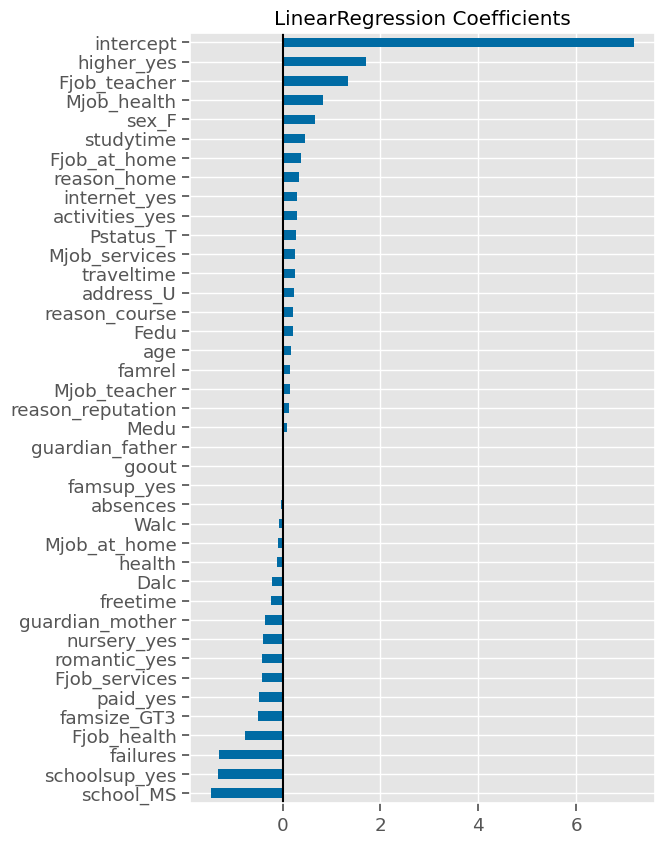

In [30]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

- When we have a large number of coefficients that are small, it can be helpful to only visualizing the largest coefficients.
- Since we have both positive and negative values, we can't simply take the .head() or .tail() like we did with feature importances. 

### Visualizing the Most Impactful Coefficients

- While our current dataset doesn't have an overwhelming number of features, that won't always be the case. 

- What do we do when we want to visualize the coefficients for our model with 100 features?
- For feature importances, we took the top n most important features but the same approach would only take the largest *positive* coefficients.

The solution is to use the absolute value of the coefficients and then rank them to determine the n largest (positive or negative).
- Pandas Series have a method for calculating the absolute value (`.abs()`) and for ranking values (`.rank()`).
    - Note that .rank() numbers the smallest value as 1 so the higher the rank the larger the coefficient.
- Let's calculate the ranks of the absolute values of our features and sort them. 

In [31]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

intercept           40.00
higher_yes          39.00
school_MS           38.00
Fjob_teacher        37.00
schoolsup_yes       36.00
failures            35.00
Mjob_health         34.00
Fjob_health         33.00
sex_F               32.00
famsize_GT3         31.00
paid_yes            30.00
studytime           29.00
Fjob_services       28.00
romantic_yes        27.00
nursery_yes         26.00
Fjob_at_home        25.00
guardian_mother     24.00
reason_home         23.00
internet_yes        22.00
activities_yes      21.00
Pstatus_T           20.00
Mjob_services       19.00
traveltime          18.00
freetime            17.00
address_U           16.00
reason_course       15.00
Fedu                14.00
Dalc                13.00
age                 12.00
famrel              11.00
Mjob_teacher        10.00
reason_reputation    9.00
health               8.00
Mjob_at_home         7.00
Medu                 6.00
Walc                 5.00
guardian_father      4.00
absences             3.00
famsup_yes  

- Let's plot the 10 most impactful coefficients.

In [32]:
top_n_features = coeff_rank.head(10)
top_n_features

intercept       40.00
higher_yes      39.00
school_MS       38.00
Fjob_teacher    37.00
schoolsup_yes   36.00
failures        35.00
Mjob_health     34.00
Fjob_health     33.00
sex_F           32.00
famsize_GT3     31.00
dtype: float64

In [33]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

intercept        7.18
higher_yes       1.69
school_MS       -1.46
Fjob_teacher     1.33
schoolsup_yes   -1.31
failures        -1.29
Mjob_health      0.82
Fjob_health     -0.77
sex_F            0.66
famsize_GT3     -0.49
dtype: float64

In [34]:
top_n = 15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

school_MS       -1.46
schoolsup_yes   -1.31
failures        -1.29
Fjob_health     -0.77
famsize_GT3     -0.49
paid_yes        -0.48
Fjob_services   -0.42
romantic_yes    -0.42
nursery_yes     -0.40
studytime        0.46
sex_F            0.66
Mjob_health      0.82
Fjob_teacher     1.33
higher_yes       1.69
intercept        7.18
dtype: float64

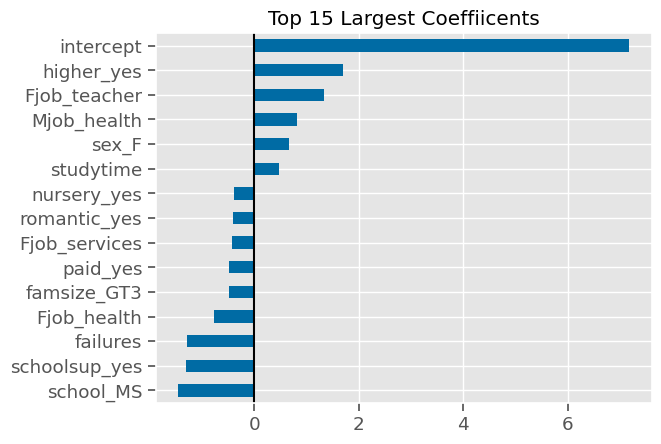

In [35]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

Notice that our intercept was one of the largest coefficients. While this can be helpful for evaluation modeling decisions, it is not as helpful for a non-technical stakeholder. 

We should convert our plotting code into a function and we should build in an argument that will give us the flexibility to decide when to include the intercept in the final plot or not. 

We can accomplish this by adding a boolean argument to our function called `intercept`. If intercept is False, then we will drop the intercept from our series before we rank our coefficients and plot them.

Since we are focused on producing insights for our stakeholders this week, we will set the default value for this argument to `False`

### Functionizing Coefficient Visualization

In [36]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):

    if intercept==False:
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"

    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

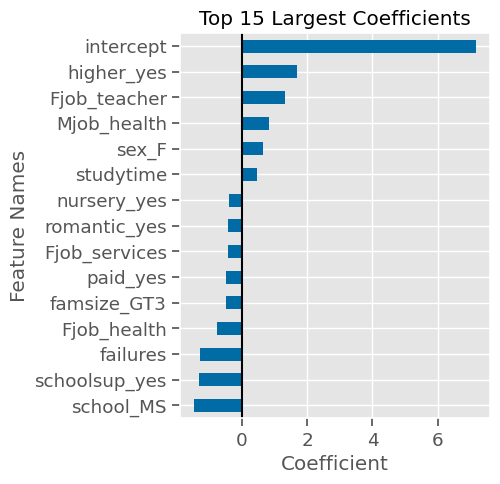

In [37]:
## Testing our function with intercept=True
ax= plot_coeffs(coeffs,top_n=15, intercept=True)

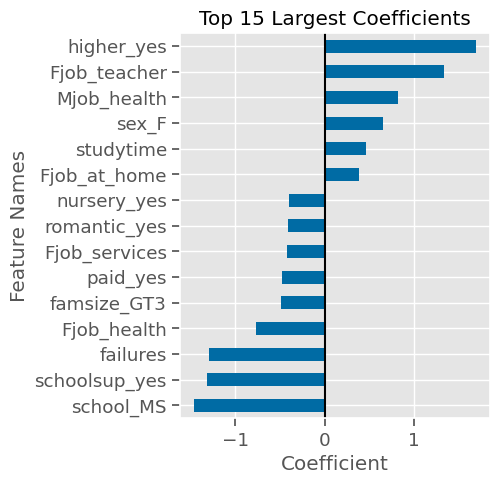

In [38]:
## Testing our function with intercept=False (the default)
ax= plot_coeffs(coeffs,top_n=15)

## Annotating Bar Graphs

- We can annotate the values of our bars programmatically using matplotlib's annotation functions and some knowledge about the structure of our figures.

- Matplotlib has an plt.annotate/ax.annotate function that allows us to add lines, arrows, and test annotations to our figure.
    - [`ax.annotate` documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html)
    
- the annotate function needs the test to annotate the "xy" cooridnates at a minimum. But there are many additional parameters that we can provide to create more involved annotations. 
    - For example, by also providing an "xytext" which will annotate the text at the xytext coodinates and then use a line to connect to the "xy" coordinates. 
    - For most of our purposes, this coordinate system should  be fine. But know that there are other options such as "figure fraction", which uses a proportion between 0 and 1 to represent the proptional distance on x and y.
    
    



#### Coordinates for Annotations
- The annotate function has a "xycoords" argument that controls what type of coordinate system it should use to place the annotation.

- By default, the xycoords is set to use the "data". Meaning that the coordinates we provide correspond to values along the x and y axis, in the same units as our data.



- Example Annotations:
    - If we wanted to add a text annotation for the 5th bar(from the bottom of the yaxis) where the xaxis ==2, we would use:

Text(1, 5, 'Example Annotation')

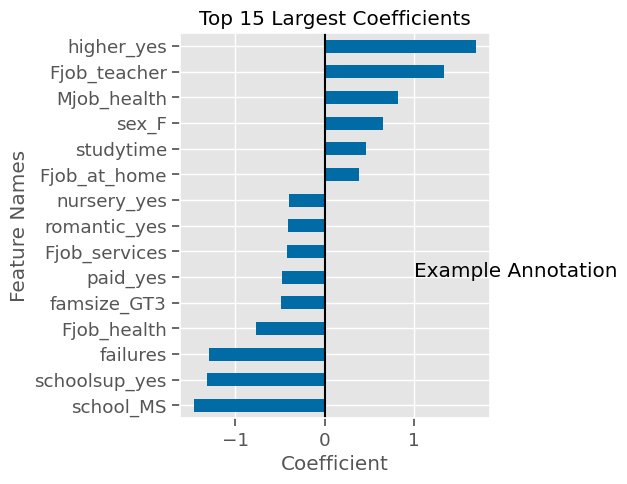

In [39]:
ax= plot_coeffs(coeffs,top_n=15)
ax.annotate("Example Annotation", xy=(1,5),)

- By adding the `xytext` argument, we can offset the text from our xy coordinate.
- We can then use the `arrowprops` argument, which is a dictionary of parameters for line/arrows.
    - For more information about what arugments are available for arrowprops, see the ["FancyArrowPatch" documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch), which is linked in the ax.annotate documentation.

Text(3, 5, 'Example Annotation')

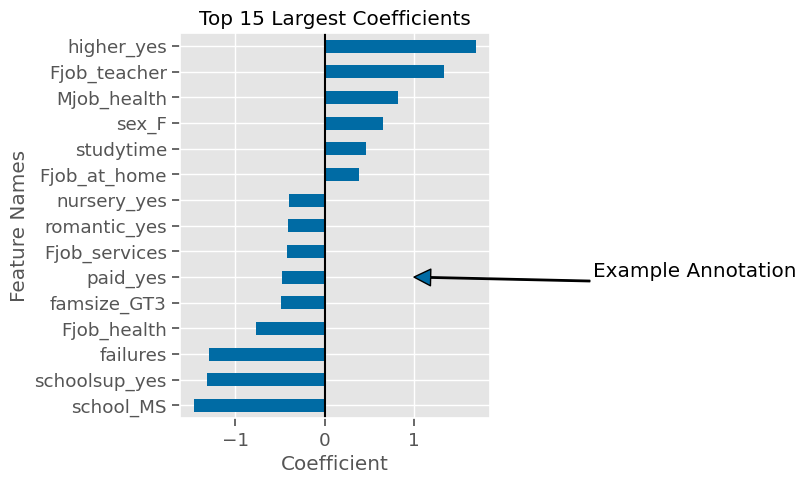

In [40]:
ax= plot_coeffs(coeffs,top_n=15)
ax.annotate("Example Annotation", xy=(1,5), xytext=(3,5),
            arrowprops={'width':1, 'ec':'k'})

- Notice that by default the annotation coordinates refer to the bottom left of the text. We can use the horizontal alignment "ha" and vertical alignment "va" arguments for ax.annotate to control this behavior.

Text(3, 5, 'Example Annotation')

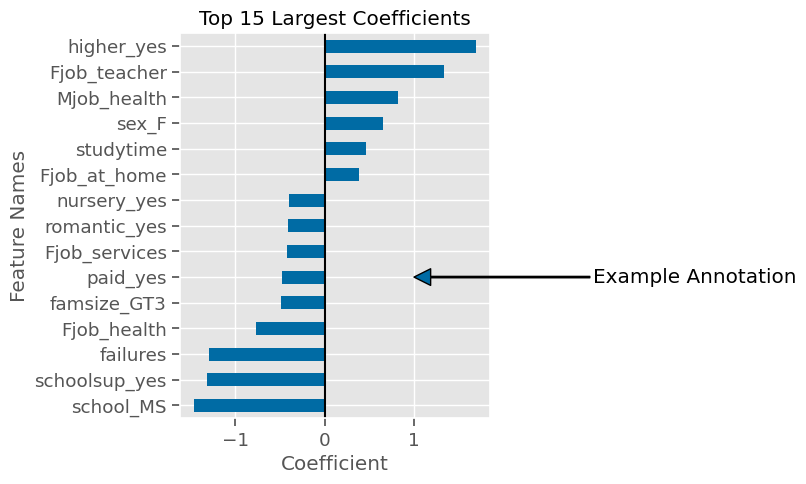

In [41]:
ax= plot_coeffs(coeffs,top_n=15)
ax.annotate("Example Annotation", xy=(1,5),xytext=(3,5),va='center',
            arrowprops={'width':1,'ec':'k'})

### Annotating Bar Heights 

- In order to programmtically annotate the values of each bar, we will need to determine the correct x and y coordinates for each bar.

- While we could use the series of coefficients to extract those values, it is not the most ideal solution, as we would need to provide that series and correctly slice out only the bars that were included in our graph.

- To make this process more streamlined and flexible, we can actually extract the coordinates from the bars themselves!

- As we used above to construct our legend, boxes on matplotlib figures are members of a class called Patch. 
- We can also extract a list of all of the patches on an axis using the `ax.patches` attribute.


In [42]:
print(type(ax.patches))

print(len(ax.patches))
ax.patches[0]

<class 'list'>
15


- As you can see above, we have a list of 15 patches, which is the number of bars on our bargraph.

- To extract the x and y coordinates from a patch,  we can use the:
    - `patch.get_height()`
    
    
- Note on bar parameters with horizontal bar charts:
    - bar.get_width() will actually return the "height" of our bar. Just keep in mind that the naming scheme of the methods is based on a normal bar chart, and that we will need to swap x/y height/width.

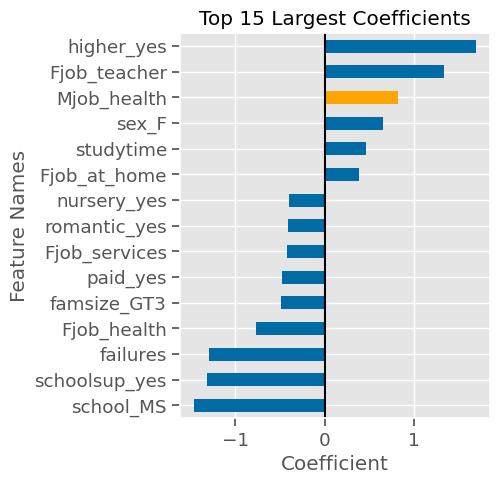

In [43]:
ax= plot_coeffs(coeffs,top_n=15)

## slicing out a test bar and changing its color to identify index
bar = ax.patches[12]
bar.set_facecolor('orange')

In [44]:
## get height returns the width of the bar for barh
bar.get_height()

0.5

In [45]:
## get width returns the height of the bar (the coefficient to annotate)
bar.get_width()

0.8217673285285533

In [46]:
## get_x will return top-left coordinate of bar (which is at x=0)
bar.get_x()

0

In [47]:
## returns the bottom coordinate of the bar
bar.get_y()

11.75

- The bar is centered on y=12 (the 12th bar) from the bottom.
    - The bar is 0.5 wide.
    - Therefore the bar is centered at 18 but extends down to 11.75 and up to 12.25
    
    
- To get the coefficient value to annotate, we will take the "width" of the bar.
- To calculate the center of the bar, we need add the height of the bar/2 to the y-position of the bar.

In [48]:
## calculate center of bar
bar_ax = bar.get_y() + bar.get_height()/2
bar_ax

12.0

In [49]:
## get the value to annotate
val = bar.get_width()
val

0.8217673285285533

- Demonstrating Annotating the value of the bar:

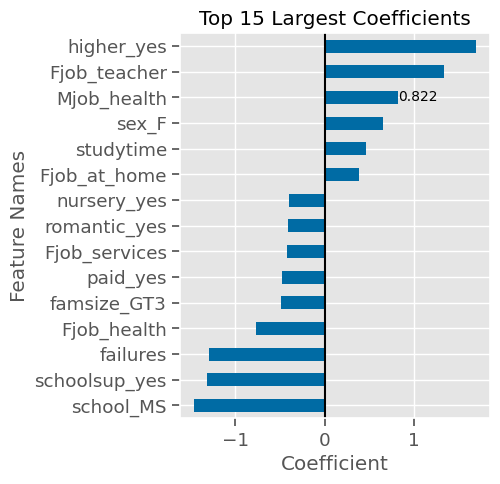

In [50]:
ax= plot_coeffs(coeffs,top_n=15)

## slicing out a test bar and changing its color to identify index
bar = ax.patches[12]


## calculate center of bar
bar_ax = bar.get_y() + bar.get_height()/2

## get the value to annotate
val = bar.get_width()

# ha and va stand for the horizontal and vertical alignment
ax.annotate(f"{val:.3f}", 
                (val,bar_ax), ha='left', va='center', size=10) ;

- We can use the xytext arg to move the text and the  textcoords arg to tell indicate we are using "offset points"

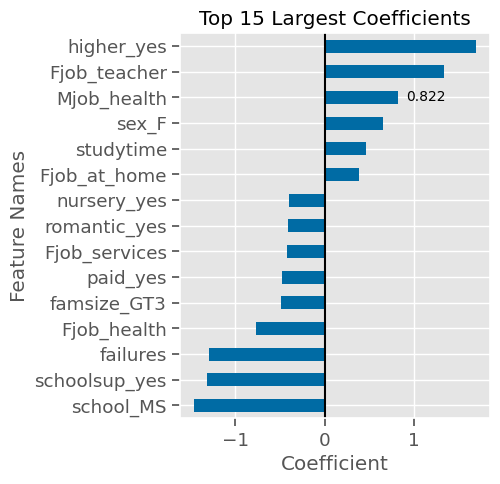

In [51]:
ax= plot_coeffs(coeffs,top_n=15)

## slicing out a test bar and changing its color to identify index
bar = ax.patches[12]


## calculate center of bar
bar_ax = bar.get_y() + bar.get_height()/2

## get the value to annotate
val = bar.get_width()

# ha and va stand for the horizontal and vertical alignment
ax.annotate(f"{val:.3f}", 
                (val,bar_ax), ha='left', va='center', size=10,
           xytext=(6,0), textcoords='offset points') ;

- Now that we have 1 bar figured out, let's make a loop to apply this to all bars.

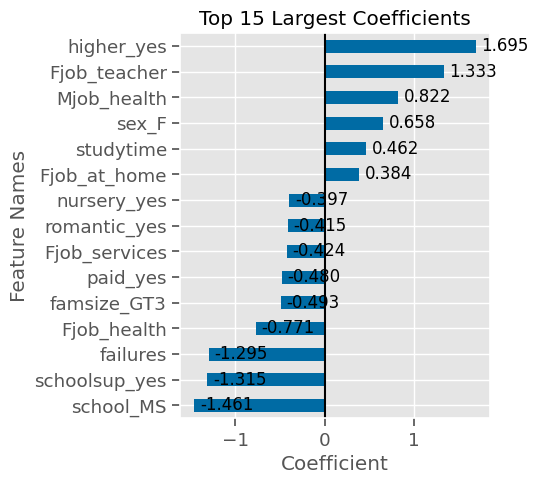

In [52]:
ax= plot_coeffs(coeffs,top_n=15)

for bar in ax.patches:

    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height()/2

    ## get the value to annotate
    val = bar.get_width()

    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.3f}", (val,bar_ax),
                ha='left',va='center',size=12,
                xytext=(4,0), textcoords='offset points')  #,textcoords='offset points')

- As we can see above, this approach doesn't handle negative bars very well. It is still placing the annotation at the same place relative to the top of the bar. However, our bars for negative coefficients overlap with our annotation.


- We can fix this by doing 2 things:
    1. Using a different variable for the value to label (val) and the value that is the top of the bar's position (val_pos)) 
    2. We then check the val of bar and if the value is less than 0, we can use set our val_pos to 0, otherwise val_pos will be equal to val.

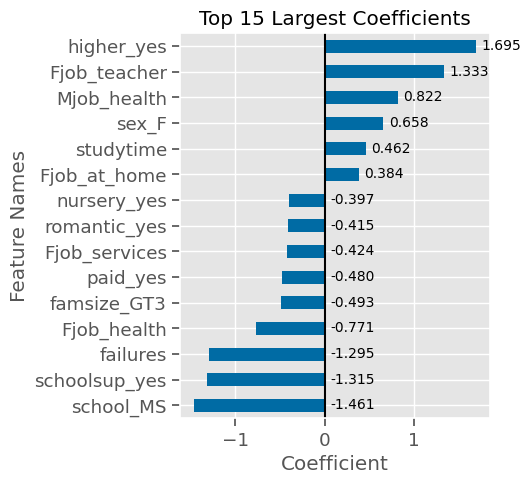

In [53]:
ax= plot_coeffs(coeffs,top_n=15)

for bar in ax.patches:

    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height()/2

    ## get the value to annotate
    val = bar.get_width()
    
    if val < 0:
        val_pos = 0
    else:
        val_pos = val
    

    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                ha='left',va='center',size=10,
                xytext=(4,0), textcoords='offset points')  #,textcoords='offset points')

### Functionalizing Annotating Horizontal Bars

In [54]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2

        ## get the value to annotate
        val = bar.get_width()

        if val < 0:
            val_pos = 0
        else:
            val_pos = val

        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

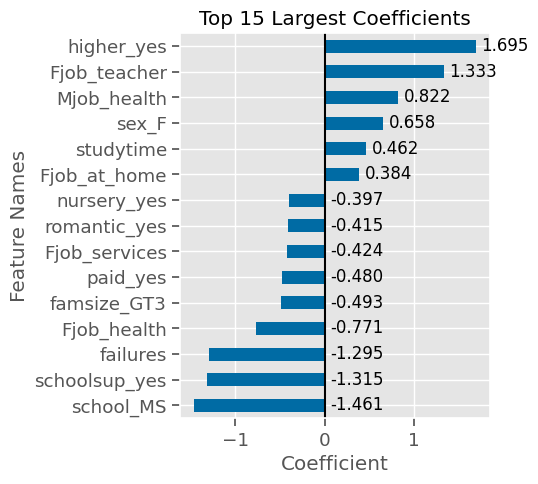

In [55]:
ax = plot_coeffs(coeffs,top_n=15)
annotate_hbars(ax)

### Final step: adding annotation to plot_coeffs

In [56]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,
                annotate=False, ha='left', va='center', size=12, xytext=(4,0),
                textcoords='offset points'):
    
    if intercept==False:
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"

    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

<AxesSubplot:title={'center':'Top 15 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

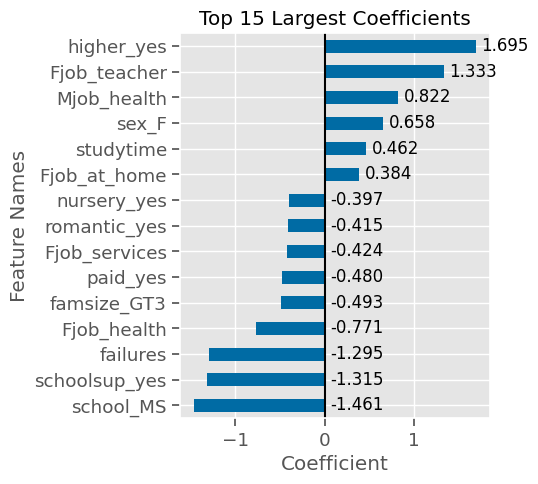

In [57]:
plot_coeffs(coeffs, top_n=15, annotate=True)

#### Additional Resources
See the following resources for more details and examples on annotating with matplotlib.
- Medium Article: [Annotating in Matplotlib](https://jessica-miles.medium.com/adding-annotations-to-visualizations-using-matplotlib-279e9c770baa)
- Matplotlib Tutorial: [Advanced Annotations](https://matplotlib.org/stable/tutorials/text/annotations.html#plotting-guide-annotation)

## Interpreting Coefficients - Linear Regression

- Let's put it all together and interpret our coefficients!

### Reminder: Interpreting Coefficients

When interpreting coefficients we need to keep in mind what transformations have been applied to our features. 
- If its a numeric feature and it has NOT been scaled:
    - The coefficient tells us "when I increase the value for this feature by **1 unit**, this is the change in the target."
- If its a numeric feature that has been scaled using Z-scores/StandardScaler:
    - The coefficient tells us "when I increase the value for this feature by **1 Standard Deviation** this is the change in the target." 
- If its a One-Hot Encoded categorical feature:
    - The coefficient tells us "if you belong to this category, this will be the change in the target" 

Training Data:	R^2= 0.35	RMSE= 2.65
Test Data:	R^2= 0.35	RMSE= 2.45


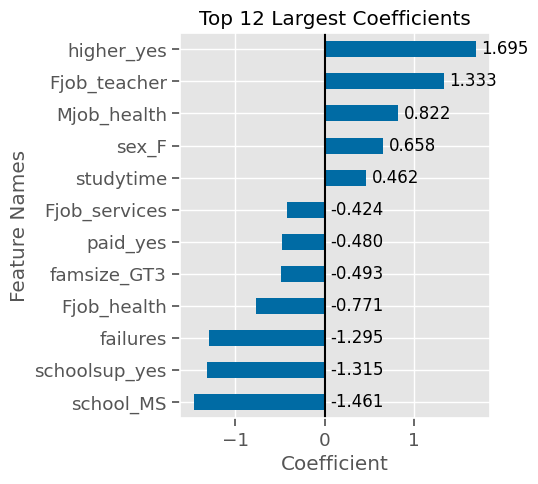

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

coeffs = get_coeffs_linreg(lin_reg)
plot_coeffs(coeffs,top_n=12,annotate=True);

#### Interpreting Our Model's Coefficients

- Intercept:
    - Our model assumed a baseline score of 7.176

- Coefficients that Positively Influence Final Grade:
    - higher_yes (student intends to continue higher education):
        - Being in the yes group (wanting hire education) increases their grade by 1.695 (out of 20)
    - Fjob_teacher (father is an educator):
        - Having a father who is a teacher increases their grade by 1.33
    - Mjob_health:
        - Having a mother who works in healthcare increases the predicted grade by 0.8.
    - sex_F:
        - Being female increases the predicted grade by 0.65
    - studytime:
        - Increasing studytime hours by 1 (according to ordinal scale) increases the predicted grade by 0.46
        - studytime (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
        
        
        
- Coefficients that Negatively Influence Final Grade:
    - school_MS:
        - Attending MS subtracted 1.461 points.
    - schoolsup_yes (getting extra education support):
        - student getting extra support decreases the predicted score by 1.3. While this may seem paradoxical at first (why would a student with MORE help perform worse?), but this could represent the effect of the student needing the extra help in the first place.
    - failures:
        - for every 1 failure, the predicted score decreases by 1.295
        
    - Fjob_health:
        - Interesting, as opposed to having a Mother in healthcare, having a father in healthcare decreases the predicted grade by .771
        
    - famesize_GT3:
        - Having a larger family (more than 3) decreases the predicted grade by .493

## Next Steps

- As we discussed in the previous lesson, if our model does not perform very well overall, we cannot trust the parameters/coefficients that it determined. 
- In the next lesson, we will take a step back and re-evaluate our business case and consider converting our regression task for improved performance and explanability.